# AKPSI Financial analysis 
## Unsupervised Learning Trading Strategy
- Download/Load SP500 stock price data
- Calculate different features and indicators on each stock
- Calculate monthly returns for different time-horizons for each stock
- Download Fama-French Factors and Calculate Rolling Factor Betas
- Visualize returns for Costco and compare to SP500 returns.
- Calculate volatility and return risk.

Code Sources: https://www.youtube.com/watch?v=9Y3yaoi9rUQ

## All Packages Needed:
- pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn

## Import dependencies

In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta 
import warnings
warnings.filterwarnings('ignore')

## 1. Download/Load SP500 stock prices 

In [4]:
# Get tickers for Stocks
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

# Get stock data; Adj close, high, low, etc..
end_date = '2024-3-11'
start_date = pd.to_datetime(end_date) -pd.DateOffset(365 * 8)
df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

# Index blocks by data and ticker date
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%%**********************]  503 of 503 completed


## 2. Calculate stock features and indicators
- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR 
- MACD
- Dollar Volume

In [10]:
df['garman_klass_vol'] = 0.5 * ((np.log(df['high'] / df['low']) ** 2) - (2 * np.log(2) - 1) * (np.log(df['adj close'] / df['open']))**2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6



## 3. Retrieve data for costco 

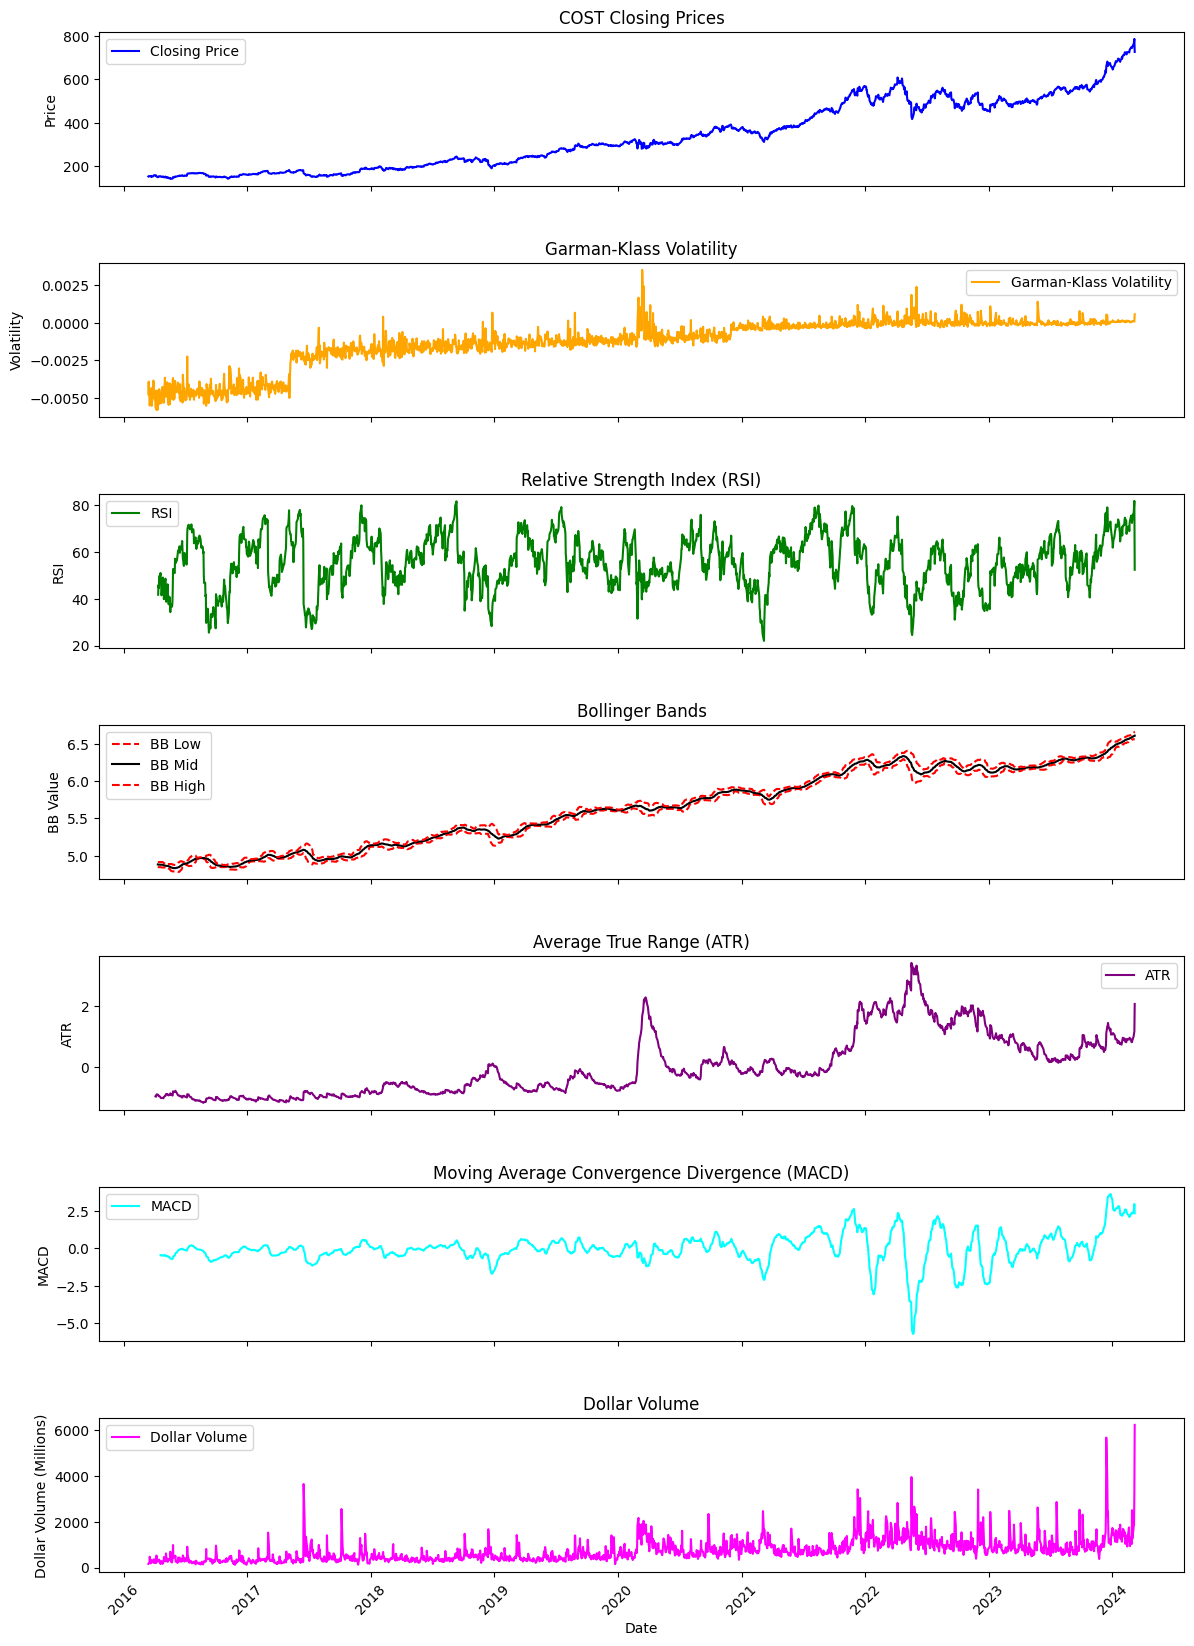

In [11]:
# Get data for costco
cost_data = df.loc[(slice(None), 'COST'), :]

# Reset index
cost_data_reset = cost_data.reset_index()

# Make sure the 'date' column is of datetime type for proper plotting
cost_data_reset['date'] = pd.to_datetime(cost_data_reset['date'])

# Set 'date' as the index for the data frame
cost_data_reset.set_index('date', inplace=True)

# Now plot All data for Costco

# Create a figure and a grid of subplots
fig, axs = plt.subplots(7, 1, figsize=(14, 20), sharex=True)

# Adjust the spacing between plots
fig.subplots_adjust(hspace=0.5)

# Closing Prices
axs[0].plot(cost_data_reset['close'], label='Closing Price', color='blue')
axs[0].set_title('COST Closing Prices')
axs[0].set_ylabel('Price')
axs[0].legend()

# Garman-Klass Volatility
axs[1].plot(cost_data_reset['garman_klass_vol'], label='Garman-Klass Volatility', color='orange')
axs[1].set_title('Garman-Klass Volatility')
axs[1].set_ylabel('Volatility')
axs[1].legend()

# RSI
axs[2].plot(cost_data_reset['rsi'], label='RSI', color='green')
axs[2].set_title('Relative Strength Index (RSI)')
axs[2].set_ylabel('RSI')
axs[2].legend()

# Bollinger Bands
axs[3].plot(cost_data_reset['bb_low'], label='BB Low', linestyle='--', color='red')
axs[3].plot(cost_data_reset['bb_mid'], label='BB Mid', linestyle='-', color='black')
axs[3].plot(cost_data_reset['bb_high'], label='BB High', linestyle='--', color='red')
axs[3].set_title('Bollinger Bands')
axs[3].set_ylabel('BB Value')
axs[3].legend()

# ATR
axs[4].plot(cost_data_reset['atr'], label='ATR', color='purple')
axs[4].set_title('Average True Range (ATR)')
axs[4].set_ylabel('ATR')
axs[4].legend()

# MACD
axs[5].plot(cost_data_reset['macd'], label='MACD', color='cyan')
axs[5].set_title('Moving Average Convergence Divergence (MACD)')
axs[5].set_ylabel('MACD')
axs[5].legend()

# Dollar Volume
axs[6].plot(cost_data_reset['dollar_volume'], label='Dollar Volume', color='magenta')
axs[6].set_title('Dollar Volume')
axs[6].set_xlabel('Date')
axs[6].set_ylabel('Dollar Volume (Millions)')
axs[6].legend()

# Rotate date labels for better readability
for ax in axs:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Show plot
plt.show()




# 4. Use linear regression models to predict whether or not Costco will increase or decrease
1. Preprocess data
2. Create target variable
3. Split data into training and testing
4. Select model
5. Train model
6. Model evaluation

In [1]:
#Preprocess

# First, select only numeric columns. This can be done using select_dtypes method
numeric_columns = cost_data_reset.select_dtypes(include=['float64', 'int64'])

# Now you can safely resample and calculate the mean for these numeric columns
monthly_averages = numeric_columns.resample('M').mean()

#Calculate a rollin average of monthly closing prices
monthly_closing_prices = cost_data_reset['close'].resample('M').last()

# Calculate the monthly price change. This will serve as our target variable
monthly_closing_prices = cost_data_reset['close'].resample('M').last()
monthly_averages['monthly_price_change_pct'] = monthly_closing_prices.pct_change()

# Download S&P 500 index data
sp500_index_data = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close'].resample('M').last().pct_change()

# Merge this data into your DataFrame
monthly_averages['market_pct_change'] = sp500_index_data.values

# Download competitor stock data (e.g., Walmart)
competitor_data = yf.download('WMT', start=start_date, end=end_date)['Adj Close'].resample('M').last().pct_change()

# Merge this data into your DataFrame
monthly_averages['competitor_pct_change'] = competitor_data.values


# Drop the first row since it will have NaN for 'monthly_price_change_pct'
monthly_averages = monthly_averages[1:]

#Train model and predict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X = monthly_averages[['garman_klass_vol', 'rsi', 'bb_low', 'bb_mid', 'bb_high', 'atr', 'macd', 'dollar_volume', 'market_pct_change', 'competitor_pct_change']]
y = monthly_averages['monthly_price_change_pct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

# Evaluate with MSE and R^2 again
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


NameError: name 'cost_data_reset' is not defined